In [1]:
include("OQS_Tools_v1.jl")
using LinearAlgebra, Plots, PolyChaos
using .OQS_Tools_v1

In [2]:
function HS_distance(A, B, n, N) #1st matrix, 2nd matrix, chain sites included, chain sites
    Ma = A[N+1-n:N+1+n,N+1-n:N+1+n]
    Mb = B[N+1-n:N+1+n,N+1-n:N+1+n]
    Id = I(2n+1)
    d2 = sqrt(0.5 * (det(Id - 2*Ma + 2*Ma*Ma) + det(Id - 2*Mb + 2*Mb*Mb) - 2*det(Id - Ma - Mb + 2*Ma*Mb)))
    return d2 #each term in D is the 'overlap' of the two correlation matrices
end

function block_entropy(C, n, N)
    Csub = C[N+1-n:N+1+n,N+1-n:N+1+n]
    Id = Matrix(1.0I, 2n+1, 2n+1)
    evals1 = eigvals(Csub)
    evals2 = eigvals(Id .- Csub)
    S = -sum(evals1 .* log.(evals1) .+ evals2 .* log.(evals2))
    return S
end

function VNentropy(C, n, N)
    Id = Matrix(1.0I, size(C))
    evals1 = eigvals(C)
    evals2 = eigvals(Id .- C)
    S = -sum(evals1 .* log.(evals1) .+ evals2 .* log.(evals2))
    return S
end

function mutual_info(C, n, N)
    Csub = C[N+1-n:N+1+n,N+1-n:N+1+n]
    Cfull = C[N+1-n:N+1, N+1-n:N+1]
    Cempty = C[N+1:N+1+n, N+1:N+1+n]
    return VNentropy(Cfull,n,N) + VNentropy(Cempty,n,N) - VNentropy(Csub,n,N)
end


mutual_info (generic function with 1 method)

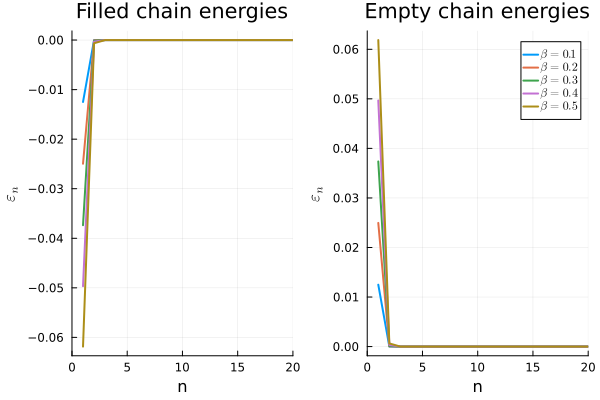

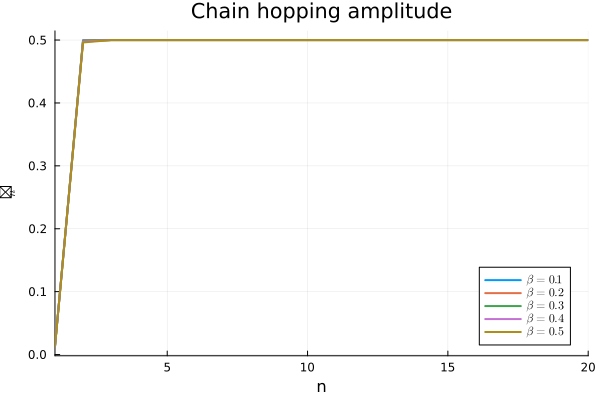

GKS: glyph missing from current font: 865
GKS: glyph missing from current font: 865
GKS: glyph missing from current font: 865
GKS: glyph missing from current font: 865
GKS: glyph missing from current font: 865
GKS: glyph missing from current font: 865


In [30]:
g = 0.001
mu = 0.0
N = 50
D = 1.0
Es = 0.0
J = create_spectral("elliptical", D, g)
p_E1 = plot()
p_E2 = plot()
p_t = plot()
for beta in 0.1:0.1:0.5
    J1, J2 = thermofield_transform(J, beta, mu)
    E1, t1 = chain_map(J1, N, D)
    E2, t2 = chain_map(J2, N, D)
     
    plot!(p_E1, E1, xlim=(0.0,20.0), xlabel="n", ylabel="\$ \\varepsilon_n \$", label="", title="Filled chain energies", lw=2)
    plot!(p_E2, E2, xlim=(0.0,20.0), xlabel="n", ylabel="\$ \\varepsilon_n \$", label="\$ \\beta = $beta \$", title="Empty chain energies", lw=2)
    plot!(p_t, t1, xlim=(1.0,20.0), xlabel="n", ylabel="\$ \\t_n \$", label="\$ \\beta = $beta \$", title="Chain hopping amplitude", lw=2)
end

display(plot(p_E1,p_E2))
display(p_t)

In [4]:
C0_full = prepare_correlations(N,sys,1.0)
C0_empty = prepare_correlations(N,sys,0.0)

Cs_full = evolve_corrs(C0_full, H, dt, tmax, N)
Cs_empty = evolve_corrs(C0_empty, H, dt, tmax, N)
len = length(Cs_full)

D = [HS_distance(Cs_full[t], Cs_empty[t], n, N) for t in 1:len]
Df = D[2:end]
Di = D[1:end-1]
dD_dt = (Df - Di)/dt
p1 = plot(real.(D),xlabel="timestep",ylabel="trace distance",title="n=$n")
p2 = plot(real.(dD_dt),xlabel="timestep",ylabel="\$ \\frac{d}{dt}\$ trace distance",title="n=$n", yrange=(-0.3,0.1))
p = plot(p1,p2)

UndefVarError: UndefVarError: `sys` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [8]:
function evolve_corrs(C0, H, dt, tmax, N)
    n = 2N + 1
    Cs = Vector{Array{ComplexF64}}(undef, 0)
    times = collect(0:dt:tmax)
    C0 = Matrix(C0)
    H = Matrix(H)

    for t in times
        U = exp(-im * t * H)
        C = U * C0 * U'
        push!(Cs, C)
    end

    return Cs
end


evolve_corrs (generic function with 1 method)

In [ ]:
D = 1.0
mu = 0.0
N=100
Esys=0.0
sys = N+1
dt = 0.1 
tmax = 300.0

p = plot(0.01:0.02:0.5)
for beta in [1.0,10.0,100.0]
    BLP = []
    for g in 0.01:0.02:0.5
        J = create_spectral("elliptical", D, g)
        J1, J2 = thermofield_transform(J, beta, mu)

        E1, h1 = chain_map(J1, N, D)
        E2, h2 = chain_map(J2, N, D)
        
        #cut = findfirst(k -> maximum(h1[k:k+10]) - minimum(h1[k:k+10]) < 0.001 , collect(1:length(h1)-10))

        H = make_H_matrix(E1, E2, h1, h2, Esys, N, sys)
        C0_full = prepare_correlations(N,sys,1.0)
        C0_empty = prepare_correlations(N,sys,0.0)
        Cs_full = evolve_corrs(C0_full, H, dt, tmax, N)
        Cs_empty = evolve_corrs(C0_empty, H, dt, tmax, N)
        len = length(Cs_full)

        d2 = [HS_distance(Cs_full[t], Cs_empty[t], 1, N) for t in 1:len]
        Df = d2[2:end]
        Di = d2[1:end-1]
        dD_dt = real.(Df-Di)
        Nphi = sum(dD_dt[dD_dt .>= 0.0])
        push!(BLP, Nphi)
    end
    plot!(p, BLP, xlabel="\$ g \$", ylabel="BLP Measure",
        title="\$ \\mu=$(mu), D=$(D) \$",label="\$ \\beta = $beta \$")
end
    

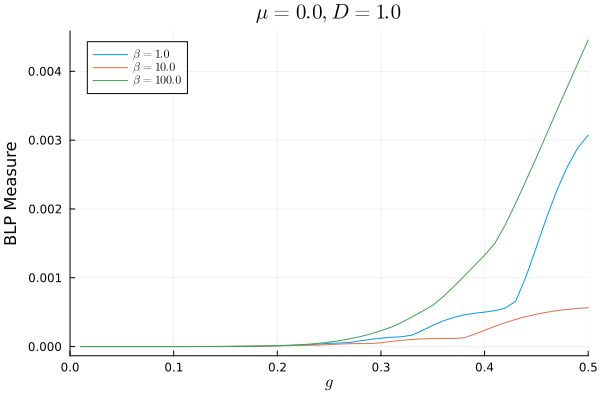

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


In [ ]:

display(p)


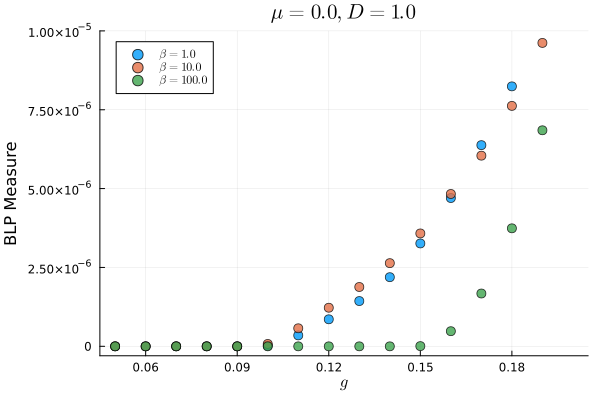

In [29]:
# Loop through every curve in the plot

xlims!(p, 0.045, 0.205)
display(p)

In [ ]:
C0 = prepare_correlations(N,sys,0.0)
Cs = evolve_corrs(C0, H, dt, tmax, N)

